<a href="https://colab.research.google.com/github/heejjj/Sleeping_Project/blob/main/ECG_Classification_%7C_CNN_LSTM_Attention_Mechanism_20230418.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REF :https://www.kaggle.com/datasets/shayanfazeli/heartbeat?select=ptbdb_normal.csv


https://www.kaggle.com/code/polomarco/ecg-classification-cnn-lstm-attention-mechanism


https://www.kaggle.com/datasets/polomarco/mitbih-with-synthetic/versions/1


In [ ]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    attn_state_path = '../content/drive/MyDrive/kaggle/attn.pth'
    lstm_state_path = '../content/drive/MyDrive/kaggle/lstm.pth'
    cnn_state_path = '../content/drive/MyDrive/kaggle/cnn.pth'
    
    attn_logs = '../content/drive/MyDrive/kaggle/attn.csv'
    lstm_logs = '../content/drive/MyDrive/kaggle/lstm.csv'
    cnn_logs = '../content/drive/MyDrive/kaggle/cnn.csv'
    
    train_csv_path = '../content/drive/MyDrive/kaggle/mitbih_with_syntetic_train.csv'
    test_csv_path = '../content/drive/MyDrive/kaggle/mitbih_with_syntetic_test.csv'

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = Config()
seed_everything(config.seed)

In [ ]:
df_ptbdb = pd.read_csv('/content/drive/MyDrive/kaggle/ptbdb_abnormal.csv')
df_mitbih = pd.read_csv('/content/drive/MyDrive/kaggle/mitbih_train.csv')
df_ptbdb

,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10501,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_mitbih_train = pd.read_csv('/content/drive/MyDrive/kaggle/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('/content/drive/MyDrive/kaggle/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [ ]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

## Basic EDA

In [ ]:
df_mitbih = pd.read_csv(config.csv_path)
df_mitbih['label'].value_counts()

Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: label, dtype: int64

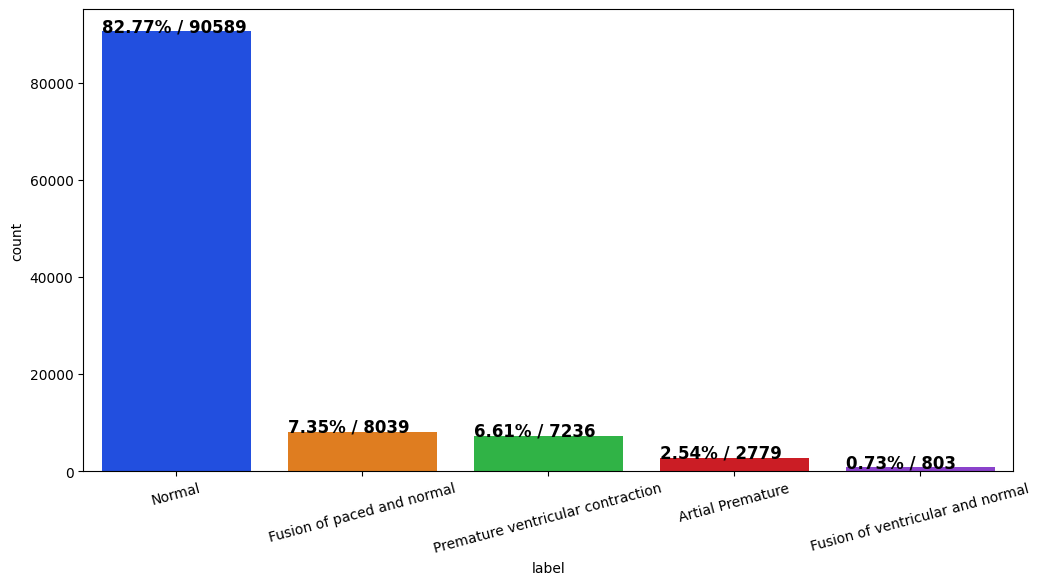

In [ ]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
config.csv_path = '../content/drive/MyDrive/kaggle/mitbih_with_syntetic.csv'
df_mitbih_new = pd.read_csv(config.csv_path)

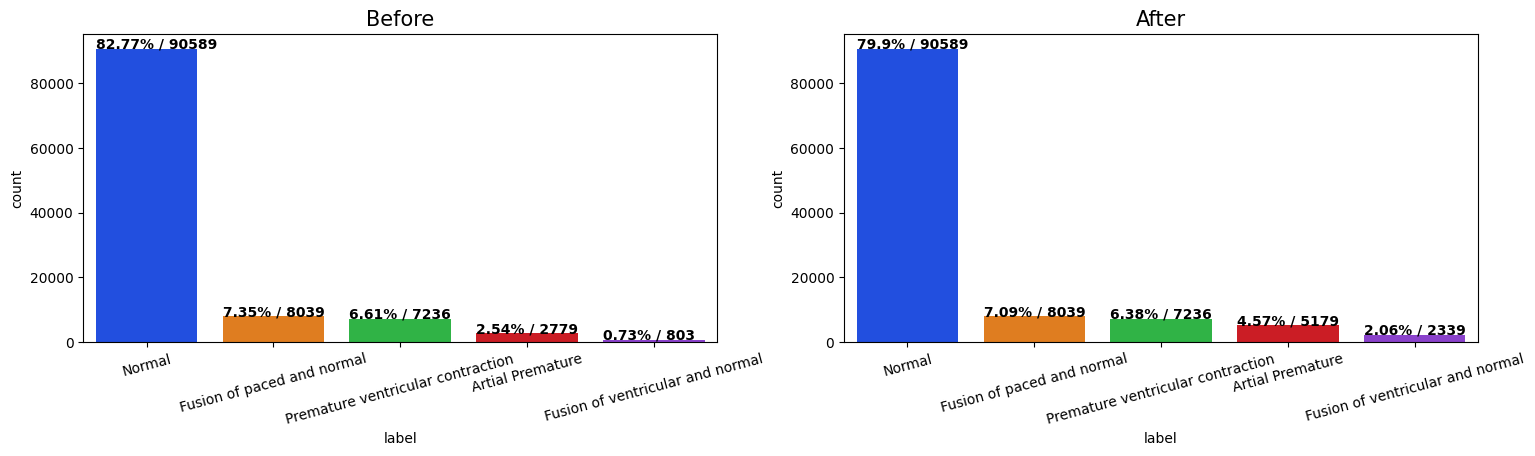

In [ ]:
percentages1 = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]
percentages2 = [count / df_mitbih_new.shape[0] * 100 for count in df_mitbih_new['label'].value_counts()]

fig, axs = plt.subplots(1,2, figsize=(18, 4))

# origin
sns.countplot(
    x=df_mitbih['label'],
    ax=axs[0],
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=15);
axs[0].set_title("Before", fontsize=15)

for percentage, count, p in zip(
    percentages1,
    df_mitbih['label'].value_counts(sort=True).values,
    axs[0].patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    axs[0].annotate(str(percentage)+" / "+str(count), (x, y), fontsize=10, fontweight='bold')

# with synthetic
sns.countplot(
    x=df_mitbih_new['label'],
    ax=axs[1],
    palette="bright",
    order=df_mitbih_new['label'].value_counts().index
)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=15);
axs[1].set_title("After", fontsize=15)

for percentage, count, p in zip(
    percentages2,
    df_mitbih_new['label'].value_counts(sort=True).values,
    axs[1].patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    axs[1].annotate(str(percentage)+" / "+str(count), (x, y), fontsize=10, fontweight='bold')

#plt.suptitle("Balanced Sampling between classes", fontsize=20, weight="bold", y=1.01)
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

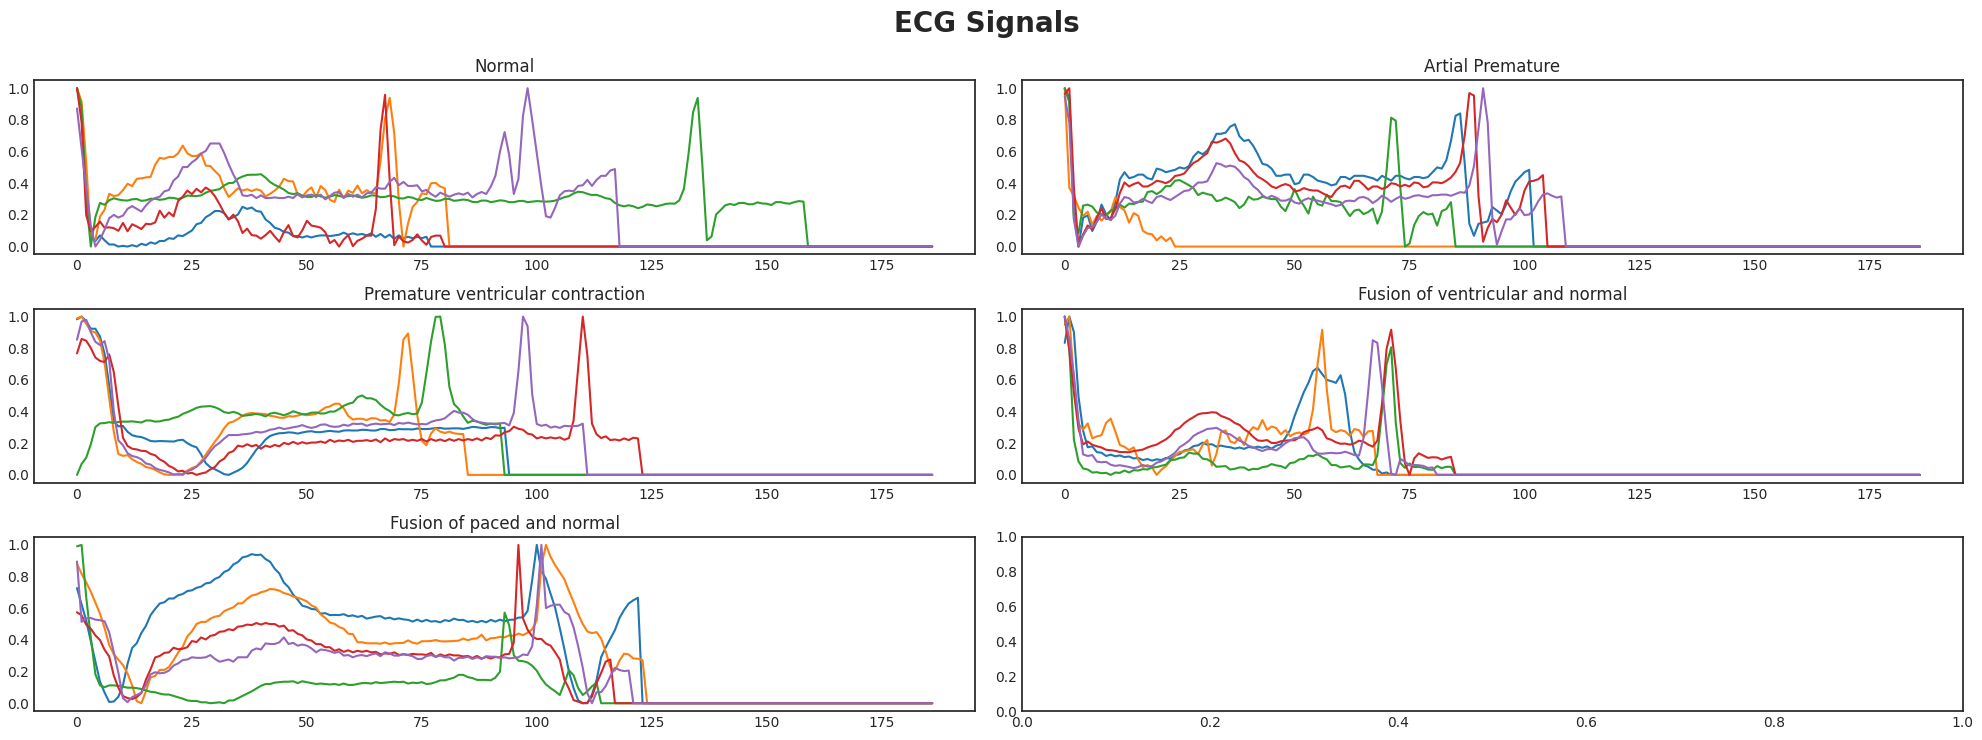

In [ ]:
N = 5
samples = [df_mitbih.loc[df_mitbih['class'] == cls].sample(N) for cls in range(N)]
titles = [id_to_label[cls] for cls in range(5)]

with plt.style.context("seaborn-white"):
    fig, axs = plt.subplots(3, 2, figsize=(20, 7))
    for i in range(5):
        ax = axs.flat[i]
        ax.plot(samples[i].values[:,:-2].transpose())
        ax.set_title(titles[i])
        #plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.suptitle("ECG Signals", fontsize=20, y=1.05, weight="bold")
    plt.savefig(f"signals_per_class.svg",
                    format="svg",bbox_inches='tight', pad_inches=0.2)
        
    plt.savefig(f"signals_per_class.png", 
                    format="png",bbox_inches='tight', pad_inches=0.2) 

In [ ]:
%%time
signals = [' '.join(df_mitbih.iloc[i, :-1].apply(str).values) for i in range(df_mitbih.shape[0])]
y = df_mitbih.iloc[:, -1].values.tolist()
print(len(signals), len(y))

print(f'data has {len(set([sig for line in signals for sig in line.split()]))} out of 16 372 411 unique values.')

109446 109446
data has 279149 out of 16 372 411 unique values.
CPU times: user 1min 14s, sys: 3.92 s, total: 1min 18s
Wall time: 1min 23s


DataSet and DataLoader

In [ ]:
class ECGDataset(Dataset):
    '''
    ECG 데이터를 위한 사용자 정의 데이터셋 클래스입니다.

    매개변수:
        df: ECG 데이터가 포함된 DataFrame입니다.

    메서드:
        __getitem__(self, idx): 데이터셋에서 단일 샘플을 가져옵니다.
        __len__(self): 데이터셋의 길이를 반환합니다.
    '''

    def __init__(self, df):
        '''
        ECGDataset을 초기화합니다.

        매개변수:
            df: ECG 데이터가 포함된 DataFrame입니다.
        '''
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        '''
        데이터셋에서 단일 샘플을 가져옵니다.

        매개변수:
            idx: 가져올 샘플의 인덱스입니다.

        반환값:
            signal: ECG 신호를 나타내는 FloatTensor입니다.
            target: 클래스 레이블을 나타내는 LongTensor입니다.
        '''
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])                 
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        '''
        데이터셋의 길이를 반환합니다.

        반환값:
            데이터셋의 길이입니다.
        '''
        return len(self.df)

In [ ]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])                 
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

In [ ]:
def get_dataloader(phase: str, batch_size: int = 96) -> DataLoader:
    '''
    데이터셋과 데이터로더를 반환하는 함수입니다.

    매개변수:
        phase: 훈련 또는 검증 단계를 나타내는 문자열입니다.
        batch_size: 각 반복마다 사용할 데이터 개수입니다.

    반환값:
        데이터 생성기(DataLoader) 객체입니다.
    '''
    df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=config.seed, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4)
    return dataloader

In [ ]:
def get_dataloader(phase: str, batch_size: int = 96) -> DataLoader:
    '''
    Dataset and DataLoader.
    Parameters:
        pahse: training or validation phase.
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=config.seed, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4)
    return dataloader

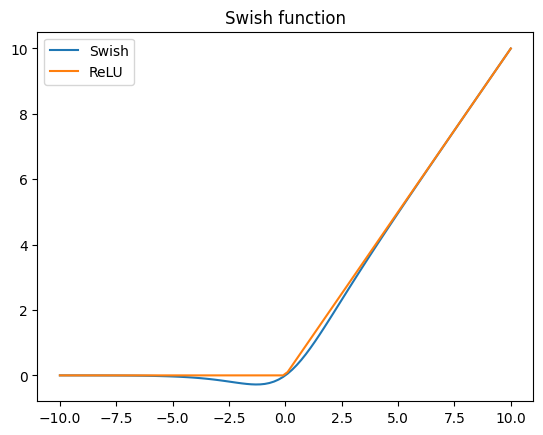

In [ ]:
class Swish(nn.Module):  # 스위시함수 정의
    def forward(self, x):
        return x * torch.sigmoid(x)
    
x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()

In [ ]:
class ConvNormPool(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()
        
        # 저장할 인자들을 초기화합니다.
        self.kernel_size = kernel_size
        
        # 첫 번째 컨볼루션 레이어를 정의합니다.
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        
        # 두 번째 컨볼루션 레이어를 정의합니다.
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        
        # 세 번째 컨볼루션 레이어를 정의합니다.
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        
        # Swish 활성화 함수를 정의합니다.
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        
        # 정규화 유형에 따라 적절한 정규화를 설정합니다.
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)
            
        # Max Pooling 레이어를 정의합니다.
        self.pool = nn.MaxPool1d(kernel_size=2)
        
    def forward(self, input):
        # 입력 데이터를 첫 번째 컨볼루션 레이어에 통과시킵니다.
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))
        
        # 첫 번째 컨볼루션의 출력을 두 번째 컨볼루션 레이어에 통과시킵니다.
        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))
        
        # 첫 번째 컨볼루션의 출력과 세 번째 컨볼루션 레이어의 출력을 더한 후 정규화합니다.
        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_

In [ ]:
class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)
            
        self.pool = nn.MaxPool1d(kernel_size=2)
        
    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))
        
        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))
        
        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))   
        
        x = self.pool(x)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size=1,
        hid_size=256,
        kernel_size=5,
        num_classes=5,
    ):
        super().__init__()
        
        # ConvNormPool 모듈을 이용하여 컨볼루션 레이어들을 정의합니다.
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        
        # AdaptiveAvgPool1d를 이용하여 고정 크기의 출력을 얻을 수 있도록 합니다.
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        
        # Fully Connected 레이어를 정의합니다.
        self.fc = nn.Linear(in_features=hid_size//4, out_features=num_classes)
        
    def forward(self, input):
        # 입력 데이터를 Convolution 레이어들을 통과시킵니다.
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # AdaptiveAvgPool1d를 사용하여 고정 크기의 출력을 얻습니다.
        x = self.avgpool(x)
        
        # x.shape: (batch_size, num_features, 1) 형태이므로 2차원으로 변환합니다.
        x = x.view(-1, x.size(1) * x.size(2))
        
        # Softmax 함수를 사용하여 클래스 확률을 계산합니다.
        x = F.softmax(self.fc(x), dim=1)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size = 1,
        hid_size = 256,
        kernel_size = 5,
        num_classes = 5,
    ):
        
        super().__init__()
        
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size//4, out_features=num_classes)
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)        
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x

In [ ]:
class RNN(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p=0.2,
        bidirectional=False,
        rnn_type='lstm',
    ):
        super().__init__()
        
        # RNN 타입에 따라 LSTM 또는 GRU 레이어를 정의합니다.
        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )
        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )
            
    def forward(self, input):
        # RNN 레이어를 통과시킨 후 출력과 hidden states을 반환합니다.
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [ ]:
class RNN(nn.Module):
    """RNN module(cell type lstm or gru)"""
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p = 0.2,
        bidirectional = False,
        rnn_type = 'lstm',
    ):
        super().__init__()
        
        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )
            
        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )
    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [ ]:
class RNNModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()
            
        # RNN 레이어를 정의합니다.
        self.rnn_layer = RNN(
            input_size=46,  # hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        
        # ConvNormPool 모듈을 이용하여 컨볼루션 레이어들을 정의합니다.
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        
        # AdaptiveAvgPool1d를 이용하여 고정 크기의 출력을 얻을 수 있도록 합니다.
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        
        # Fully Connected 레이어를 정의합니다.
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        # 입력 데이터를 Convolution 레이어들을 통과시킵니다.
        x = self.conv1(input)
        x = self.conv2(x)
        
        # RNN 레이어를 통과시킨 후 출력을 얻습니다.
        x, _ = self.rnn_layer(x)
        
        # AdaptiveAvgPool1d를 사용하여 고정 크기의 출력을 얻습니다.
        x = self.avgpool(x)
        
        # x.shape: (batch_size, num_features, 1) 형태이므로 2차원으로 변환합니다.
        x = x.view(-1, x.size(1) * x.size(2))
        
        # Softmax 함수를 사용하여 클래스 확률을 계산합니다.
        x = F.softmax(self.fc(x), dim=1)
        return x

RNNModel 클래스는 Convolution 레이어와 RNN 레이어를 조합하여 구현한 모델입니다. 생성자에서는 입력 크기, 은닉 크기, RNN 타입 (LSTM 또는 GRU), 양방향 여부, 클래스 수 등의 인수를 받습니다.

forward 함수에서는 입력 데이터를 Convolution 레이어를 통과시키고, 그 결과를 RNN 레이어에 입력합니다. RNN 레이어의 출력을 AdaptiveAvgPool1d를 사용하여 고정 크기의 출력으로 변환한 후, 이를 Fully Connected 레이어를 통과시켜 클래스 확률을 계산합니다.

In [ ]:
class RNNModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()
            
        self.rnn_layer = RNN(
            input_size=46,#hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)#.squeeze(1)
        return x

In [ ]:
class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()
 
        # RNN 레이어를 정의합니다.
        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        
        # ConvNormPool 모듈을 이용하여 컨볼루션 레이어들을 정의합니다.
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        
        # AdaptiveMaxPool1d를 이용하여 고정 크기의 출력을 얻을 수 있도록 합니다.
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        
        # Attention을 위한 선형 레이어를 정의합니다.
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        
        # Fully Connected 레이어를 정의합니다.
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)
        
    def forward(self, input):
        # 입력 데이터를 Convolution 레이어들을 통과시킵니다.
        x = self.conv1(input)
        x = self.conv2(x)
        
        # RNN 레이어를 통과시킨 후 출력과 hidden states을 얻습니다.
        x_out, hid_states = self.rnn_layer(x)
        
        # hidden states를 결합하고 차원을 변경하여 Attention에 입력합니다.
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        
        # Attention을 적용하여 출력에 가중치를 부여합니다.
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        
        # AdaptiveMaxPool1d를 사용하여 고정 크기의 출력을 얻습니다.
        x = self.avgpool(x)
        
        # x.shape: (batch_size, num_features, 1) 형태이므로 2차원으로 변환합니다.
        x = x.view(-1, x.size(1) * x.size(2))
        
        # Softmax 함수를 사용하여 클래스 확률을 계산합니다.
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [ ]:
class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()
 
        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

Training Stage

In [ ]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}  # 메트릭을 저장하기 위한 딕셔너리
        self.confusion = torch.zeros((n_classes, n_classes))  # 혼동 행렬을 저장하기 위한 2D 텐서
    
    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)  # 예측값을 one-hot에서 레이블 형태로 변환
        y = y.detach().cpu().numpy()  # 실제 레이블을 넘파이 배열로 변환
        
        # 손실 및 다양한 메트릭 업데이트
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x, y)
        self.metrics['f1'] += f1_score(x, y, average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x, y, average='macro', zero_division=1)
        
        self._compute_cm(x, y)  # 혼동 행렬 계산
        
    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:  # 정답과 예측이 일치할 경우
                self.confusion[target][target] += 1  # 해당 클래스에 대해 정답 개수를 증가
            else:  # 정답과 예측이 다를 경우
                self.confusion[target][prob] += 1  # 혼동 행렬에서 해당 위치의 값을 증가
        
    def init_metrics(self):
        # 메트릭 초기화
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0
        
    def get_metrics(self):
        # 현재까지 계산된 메트릭을 반환
        return self.metrics
    
    def get_confusion_matrix(self):
        # 혼동 행렬 반환
        return self.confusion

In [ ]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))
    
    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)
        
        self._compute_cm(x, y)
        
    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1
    
    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0
        
    def get_metrics(self):
        return self.metrics
    
    def get_confusion_matrix(self):
        return self.confusion

In [ ]:
class Trainer:
    def __init__(self, net, lr, batch_size, num_epochs):
        # Trainer 클래스를 주어진 네트워크, 학습률, 배치 크기, 에폭 수로 초기화합니다.
        self.net = net.to(config.device)  # 네트워크를 지정된 장치로 이동합니다.
        self.num_epochs = num_epochs  # 에폭 수를 설정합니다.
        self.criterion = nn.CrossEntropyLoss()  # 손실 함수를 CrossEntropyLoss로 정의합니다.
        self.optimizer = AdamW(self.net.parameters(), lr=lr)  # 주어진 학습률로 AdamW 옵티마이저를 초기화합니다.
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)  # 학습률 조정을 위한 스케줄러를 설정합니다.
        self.best_loss = float('inf')  # 최적의 손실을 양의 무한대로 초기화합니다.
        self.phases = ['train', 'val']  # 'train'과 'val'로 단계를 정의합니다.
        self.dataloaders = {
            phase: get_dataloader(phase, batch_size) for phase in self.phases
        }  # 제공된 배치 크기로 각 단계에 대한 데이터 로더를 생성합니다.
        self.train_df_logs = pd.DataFrame()  # 훈련 로그를 저장할 빈 DataFrame을 초기화합니다.
        self.val_df_logs = pd.DataFrame()  # 검증 로그를 저장할 빈 DataFrame을 초기화합니다.
    
    def _train_epoch(self, phase):
        # 주어진 단계에 대해 한 번의 에폭을 수행합니다.
        print(f"{phase} 모드 | 시간: {time.strftime('%H:%M:%S')}")  # 현재 단계와 시간을 출력합니다.
        
        self.net.train() if phase == 'train' else self.net.eval()  # 단계에 따라 네트워크를 훈련 모드 또는 평가 모드로 설정합니다.
        meter = Meter()  # 메트릭을 추적하기 위해 Meter 클래스의 인스턴스를 생성합니다.
        meter.init_metrics()  # 메트릭을 초기화합니다.
        
        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(config.device)  # 데이터를 지정된 장치로 이동합니다.
            target = target.to(config.device)  # 타겟을 지정된 장치로 이동합니다.
            
            output = self.net(data)  # 순전파: 네트워크의 출력을 계산합니다.
            loss = self.criterion(output, target)  # 손실을 계산합니다.
            
            if phase == 'train':
                self.optimizer.zero_grad()  # 그라디언트를 초기화합니다.
                loss.backward()  # 역전파: 손실에 대한 모델 파라미터의 그라디언트를 계산합니다.
                self.optimizer.step()  # 그라디언트를 기반으로 파라미터를 업데이트합니다.
            
            meter.update(output, target, loss.item())  # 출력, 타겟 및 손실을 기반으로 meter를 업데이트합니다.
        
        metrics = meter.get_metrics()  # meter에서 계산된 메트릭을 가져옵니다.
        metrics = {k:v / i for k, v in metrics.items()}  # 평균 메트릭을 계산합니다.
        df_logs = pd.DataFrame([metrics])  # 메트릭을 DataFrame으로 생성합니다.
        
        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)  # 훈련 로그에 현재 에폭의 메트릭을 추가합니다.
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)  # 검증 로그에 현재 에폭의 메트릭을 추가합니다.
        
        # 로그 표시
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )  # 메트릭을 출력합니다.
        fig, ax = plt.subplots(figsize=(5, 5))  # 새로운 Figure와 Axes를 생성합니다.
        cm_ = ax.imshow(confusion_matrix, cmap='hot')  # Confusion Matrix를 이미지로 표시합니다.
        ax.set_title('Confusion matrix', fontsize=15)  # 제목을 설정합니다.
        ax.set_xlabel('Actual', fontsize=13)  # x축 레이블을 설정합니다.
        ax.set_ylabel('Predicted', fontsize=13)  # y축 레이블을 설정합니다.
        plt.colorbar(cm_)  # 컬러바를 추가합니다.
        plt.show()  # 플롯을 출력합니다.
        
        return loss
    
    def run(self):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train')  # 훈련 단계에서 한 에폭을 실행합니다.
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')  # 검증 단계에서 한 에폭을 실행하고 검증 손실을 계산합니다.
                self.scheduler.step()  # 스케줄러를 통해 학습률을 조정합니다.
            
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\n새로운 체크포인트\n')
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")  # 현재 가장 좋은 모델을 저장합니다.


In [ ]:
class Trainer:
    def __init__(self, net, lr, batch_size, num_epochs):
        self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()
    
    def _train_epoch(self, phase):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")
        
        self.net.train() if phase == 'train' else self.net.eval()
        meter = Meter()
        meter.init_metrics()
        
        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(config.device)
            target = target.to(config.device)
            
            output = self.net(data)
            loss = self.criterion(output, target)
                        
            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            meter.update(output, target, loss.item())
        
        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()
        
        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)
        
        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()
        
        return loss
    
    def run(self):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train')
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')
                self.scheduler.step()
            
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
            #clear_output()

In [ ]:
#model = RNNAttentionModel(1, 64, 'lstm', False)
#model = RNNModel(1, 64, 'lstm', True)
model = CNN(num_classes=5, hid_size=128)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train mode | time: 05:48:44


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Crea

loss: 1.0051069121288108, accuracy: 0.9313903093880973, f1: 0.7472214433172785, precision: 0.7389783686707176, recall: 0.915632693401277


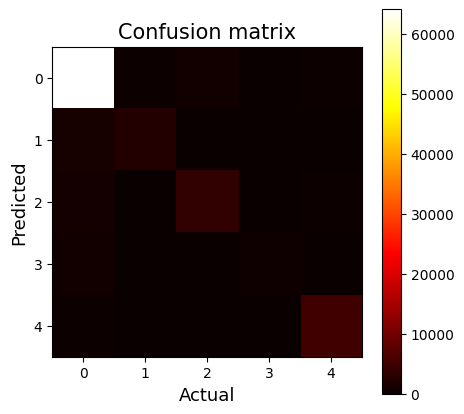

val mode | time: 05:51:41


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9603736905256907, accuracy: 0.9624524853801169, f1: 0.8534976706444702, precision: 0.8305261477030296, recall: 0.9556894037923835


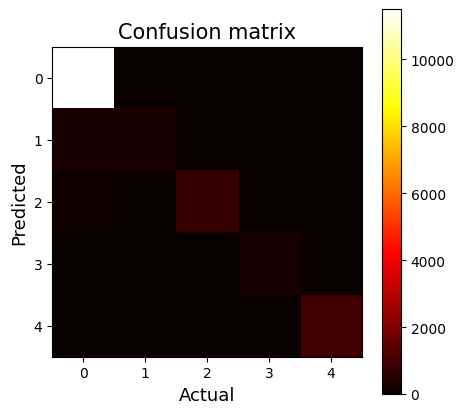


New checkpoint

train mode | time: 05:52:01


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9380382687936495, accuracy: 0.971725889692903, f1: 0.9033496009796533, precision: 0.8910074880798192, recall: 0.9562992709906246


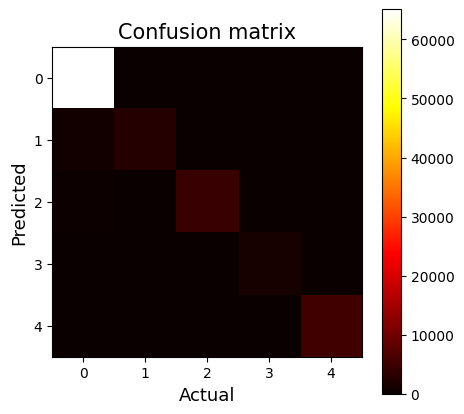

val mode | time: 05:54:43


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.941387456258138, accuracy: 0.9773611111111112, f1: 0.923592944111824, precision: 0.9053817478923992, recall: 0.9681860923766019


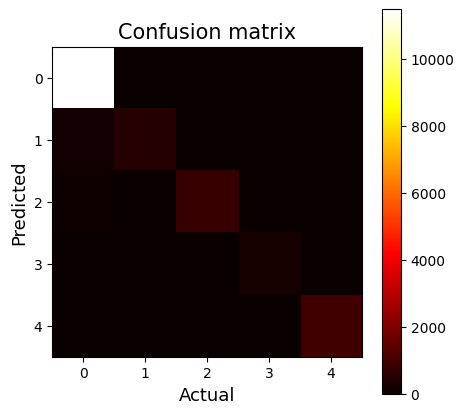


New checkpoint

train mode | time: 05:54:58


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9308409878125923, accuracy: 0.977685248817562, f1: 0.9223834087279529, precision: 0.9085174994783467, recall: 0.9700891371808198


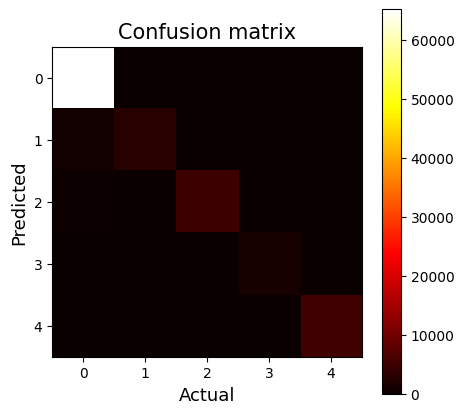

val mode | time: 05:57:39


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.936571329832077, accuracy: 0.9816191520467837, f1: 0.9340130038837814, precision: 0.9144741844607427, recall: 0.979430605869947


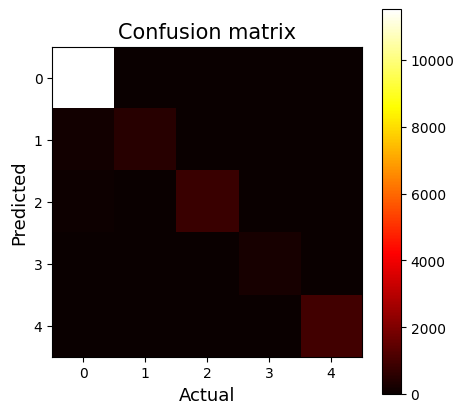

train mode | time: 05:57:53


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9271950442234769, accuracy: 0.9810312824244395, f1: 0.9321019944892616, precision: 0.918865825983198, recall: 0.9756565507482142


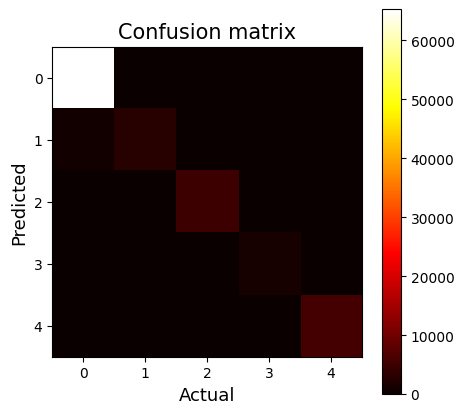

val mode | time: 06:00:37


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.933550997575124, accuracy: 0.9852521929824563, f1: 0.9342505476363624, precision: 0.9287801102899923, recall: 0.9695245285462086


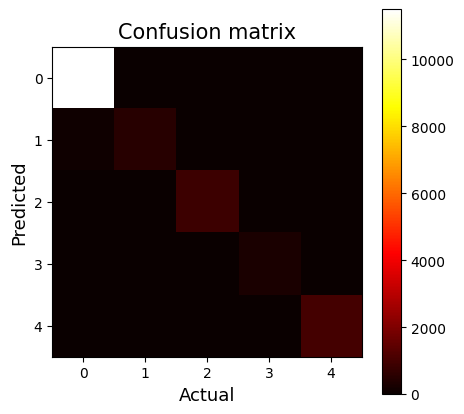

train mode | time: 06:00:51


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9249437596705706, accuracy: 0.9829363234560928, f1: 0.9356446500408893, precision: 0.9244245627046639, recall: 0.9780592830960172


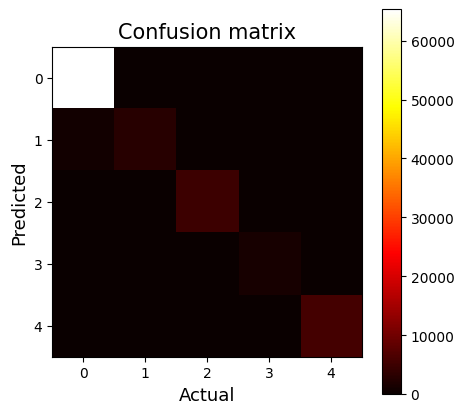

val mode | time: 06:03:32


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9303509998321533, accuracy: 0.9877083333333333, f1: 0.9447441904759798, precision: 0.9267368814403579, recall: 0.988876237222416


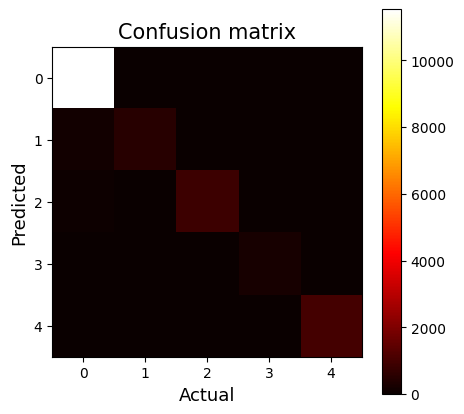


New checkpoint

train mode | time: 06:03:46


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9231802169211725, accuracy: 0.9844994340461672, f1: 0.9426304615328086, precision: 0.931074462155196, recall: 0.9813745181099744


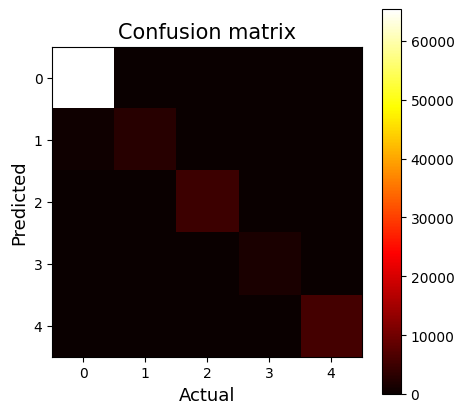

val mode | time: 06:06:27


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.930219132900238, accuracy: 0.987916666666667, f1: 0.9461964753502354, precision: 0.9330240589051578, recall: 0.9830308310059263


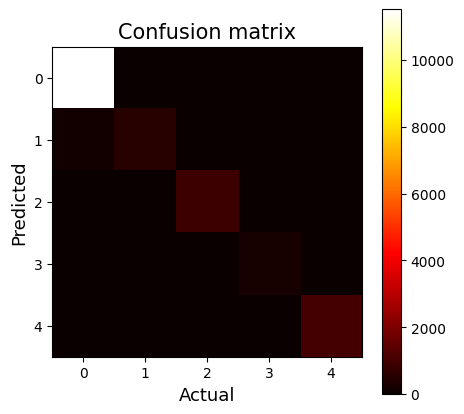

train mode | time: 06:06:41


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9217466129926836, accuracy: 0.9859160030184223, f1: 0.9455849010376364, precision: 0.9330911455161008, recall: 0.9851329661824159


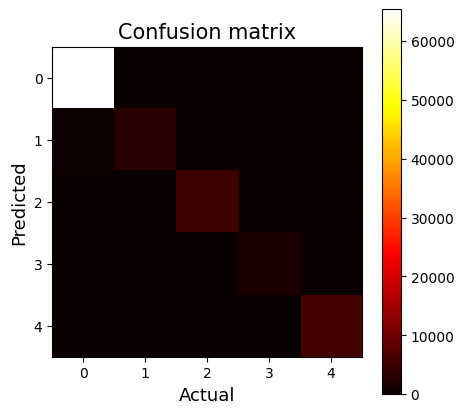

val mode | time: 06:09:22


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9302191599210103, accuracy: 0.9881250000000001, f1: 0.948428355620373, precision: 0.9361504721626752, recall: 0.9831738288828021


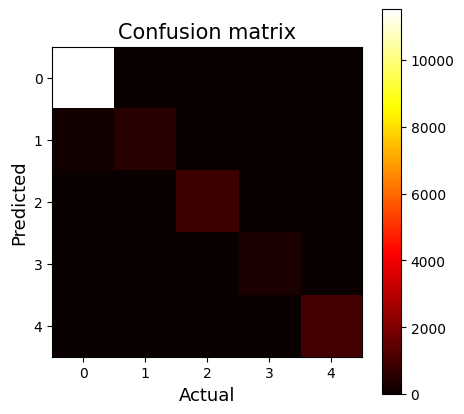

train mode | time: 06:09:36


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9207389997569506, accuracy: 0.9866487111075198, f1: 0.9486343467353985, precision: 0.9367229724778108, recall: 0.985756668488205


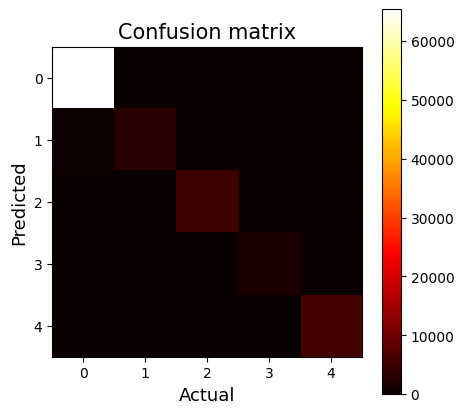

val mode | time: 06:12:17


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9291513705253601, accuracy: 0.9886805555555558, f1: 0.9486011015754643, precision: 0.935061678950501, recall: 0.9859308716094859


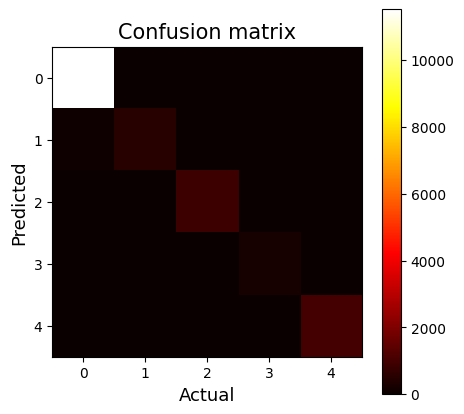

train mode | time: 06:12:31


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9199507459386711, accuracy: 0.9873447837921625, f1: 0.9500529469510498, precision: 0.9377965380840514, recall: 0.9873232689234711


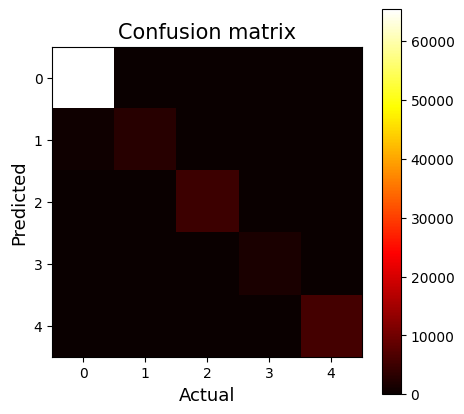

val mode | time: 06:15:11


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.928137325445811, accuracy: 0.9898611111111116, f1: 0.950416389073709, precision: 0.9357316136713996, recall: 0.9884129722082498


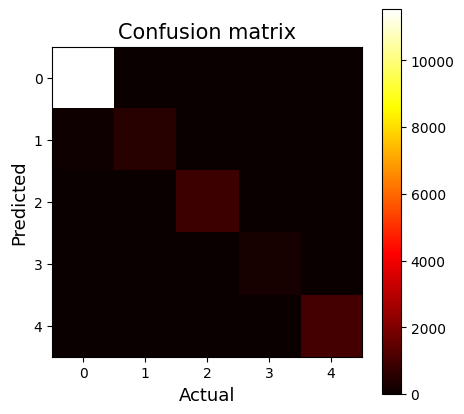

train mode | time: 06:15:25


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9194348188245981, accuracy: 0.9878088322485907, f1: 0.9523574641374118, precision: 0.9397365105135251, recall: 0.9883867482245168


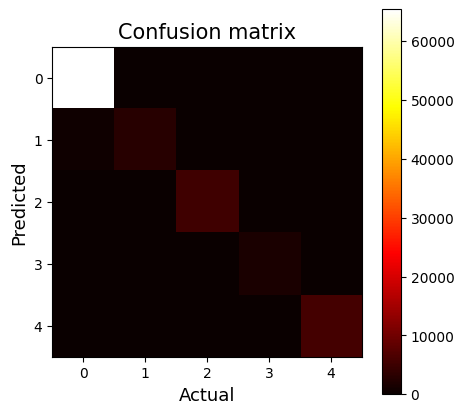

val mode | time: 06:18:06


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy

loss: 0.9278271814187368, accuracy: 0.9900694444444453, f1: 0.9512074487970058, precision: 0.9365164234596733, recall: 0.9888655962715287


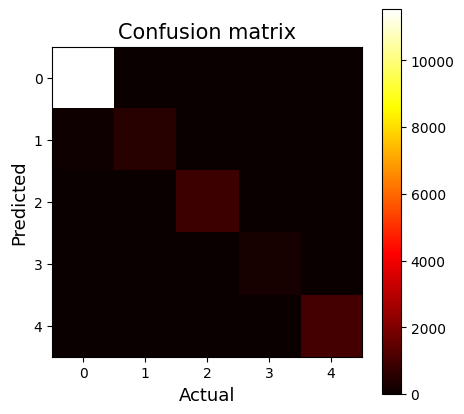

In [ ]:
trainer = Trainer(net=model, lr=1e-3, batch_size=96, num_epochs=10)#100)
trainer.run()

In [ ]:
train_logs = trainer.train_df_logs
train_logs.columns = ["train_"+ colname for colname in train_logs.columns]
val_logs = trainer.val_df_logs
val_logs.columns = ["val_"+ colname for colname in val_logs.columns]

logs = pd.concat([train_logs,val_logs], axis=1)
logs.reset_index(drop=True, inplace=True)
logs = logs.loc[:, [
    'train_loss', 'val_loss', 
    'train_accuracy', 'val_accuracy', 
    'train_f1', 'val_f1',
    'train_precision', 'val_precision',
    'train_recall', 'val_recall']
                                 ]
logs.head()
logs.to_csv('cnn.csv', index=False)

Experiments and Results

In [ ]:
cnn_model = CNN(num_classes=5, hid_size=128).to(config.device)
cnn_model.load_state_dict(
    torch.load(config.cnn_state_path,
               map_location=config.device)
);
cnn_model.eval();
logs = pd.read_csv(config.cnn_logs)

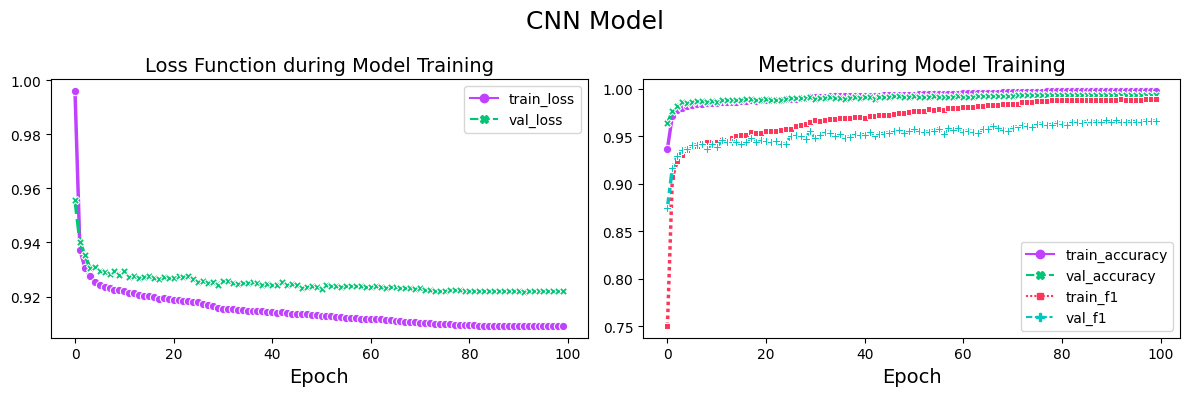

In [ ]:
colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
palettes = [sns.color_palette(colors, 2),
            sns.color_palette(colors, 4), 
            sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
ax[0].set_title("Loss Function during Model Training", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)

sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
ax[1].set_title("Metrics during Model Training", fontsize=15)
ax[1].set_xlabel("Epoch", fontsize=14)

plt.suptitle('CNN Model', fontsize=18)

plt.tight_layout()
fig.savefig("cnn.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
lstm_model = RNNModel(1, 64, 'lstm', True).to(config.device)
lstm_model.load_state_dict(
    torch.load(config.lstm_state_path,
               map_location=config.device)
);
lstm_model.eval();
logs = pd.read_csv(config.lstm_logs)

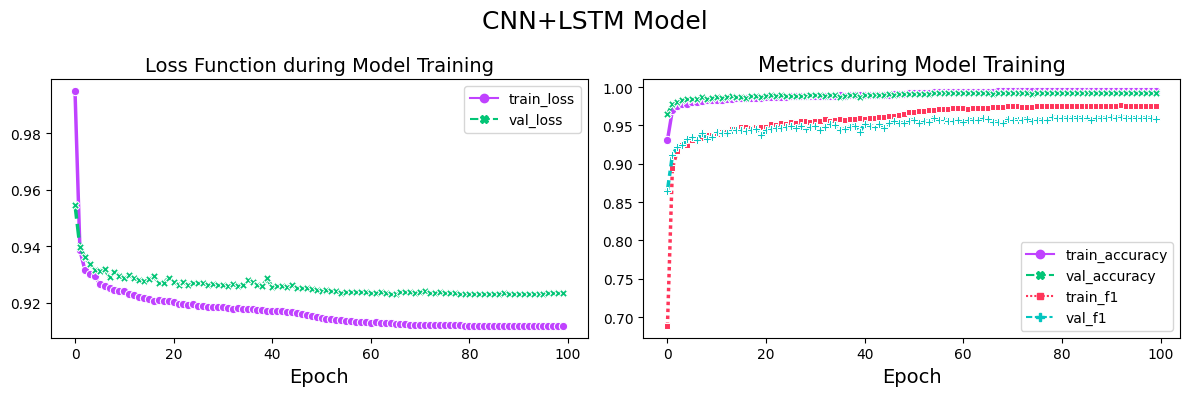

In [ ]:
colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
palettes = [sns.color_palette(colors, 2),
            sns.color_palette(colors, 4), 
            sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
ax[0].set_title("Loss Function during Model Training", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)

sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
ax[1].set_title("Metrics during Model Training", fontsize=15)
ax[1].set_xlabel("Epoch", fontsize=14)

plt.suptitle('CNN+LSTM Model', fontsize=18)

plt.tight_layout()
fig.savefig("lstm.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("lstm.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
attn_model = RNNAttentionModel(1, 64, 'lstm', False).to(config.device)
attn_model.load_state_dict(
    torch.load(config.attn_state_path,
               map_location=config.device)
);
attn_model.eval();
logs = pd.read_csv(config.attn_logs)

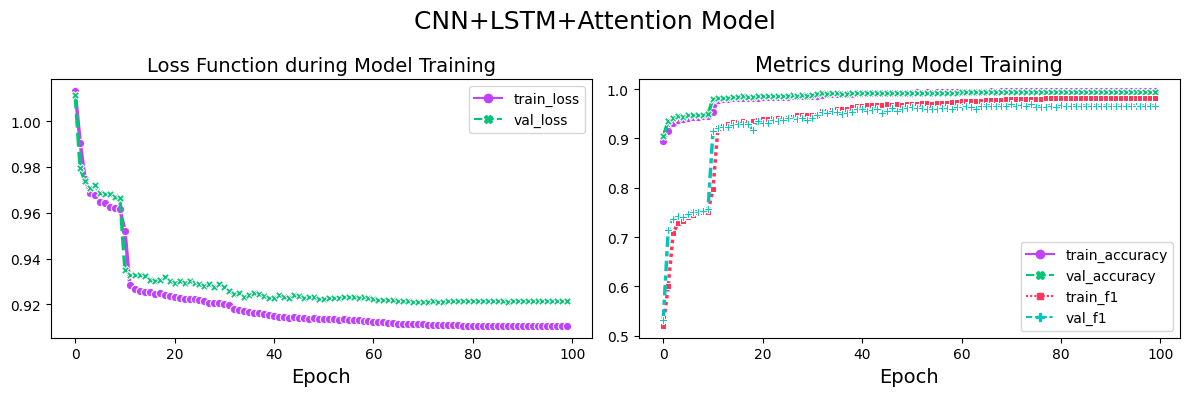

In [ ]:
colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
palettes = [sns.color_palette(colors, 2),
            sns.color_palette(colors, 4), 
            sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
ax[0].set_title("Loss Function during Model Training", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)

sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
ax[1].set_title("Metrics during Model Training", fontsize=15)
ax[1].set_xlabel("Epoch", fontsize=14)

plt.suptitle('CNN+LSTM+Attention Model', fontsize=18)

plt.tight_layout()
fig.savefig("attn.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("attn.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
test_df = pd.read_csv(config.test_csv_path)
print(test_df.shape)
test_dataset = ECGDataset(test_df)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=96, num_workers=0, shuffle=False)

(17008, 189)


In [ ]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():

            data = data.to(config.device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)
            
            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)
    
            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls

In [ ]:
models = [cnn_model, lstm_model, attn_model]

Cnn model report

In [ ]:
y_pred, y_true = make_test_stage(test_dataloader, models[0])
y_pred.shape, y_true.shape

<ipython-input-12-8280d9e6efbe>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  signal = torch.FloatTensor([signal.values])


((17008,), (17008,))

In [ ]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

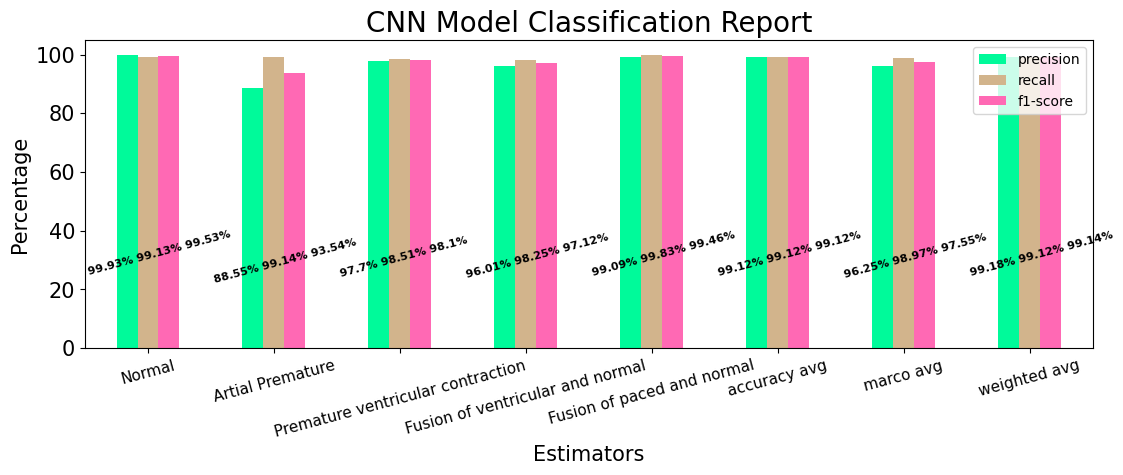

In [ ]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("cnn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

Cnn+Lstm model report

In [ ]:
y_pred, y_true = make_test_stage(test_dataloader, models[1])
y_pred.shape, y_true.shape

((17008,), (17008,))

In [ ]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

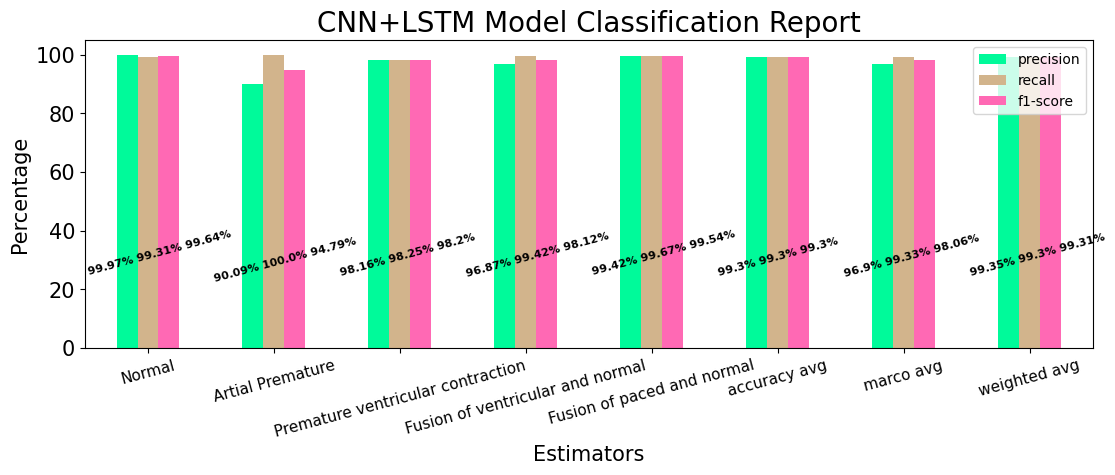

In [ ]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("lstm_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("lstm_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

Cnn+Lstm+Attention model report

In [ ]:
y_pred, y_true = make_test_stage(test_dataloader, models[2])
y_pred.shape, y_true.shape

((17008,), (17008,))

In [ ]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

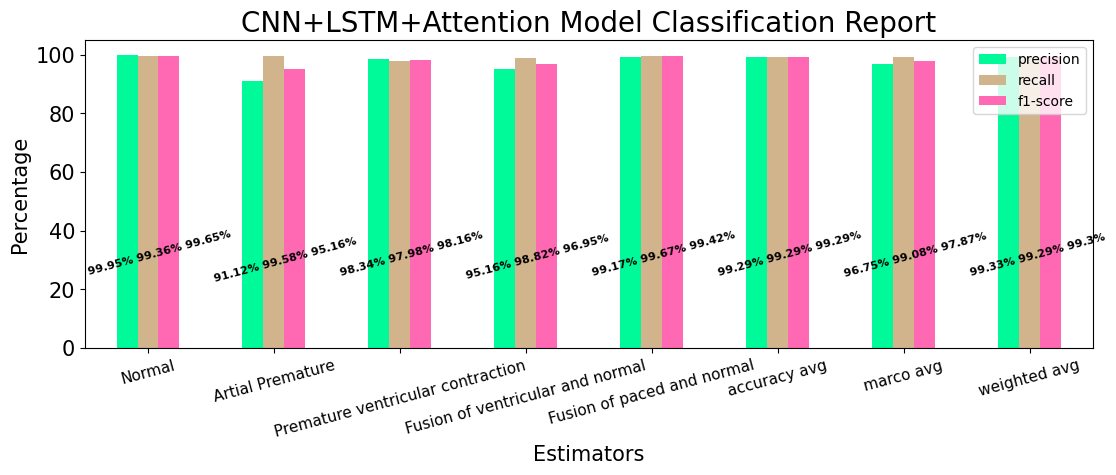

In [ ]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM+Attention Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("attn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("attn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

Ensemble of all models

In [ ]:
y_pred = np.zeros((y_pred.shape[0], 5), dtype=np.float32)
for i, model in enumerate(models, 1):
    y_pred_, y_true = make_test_stage(test_dataloader, model, True)
    y_pred += y_pred_
y_pred /= i
y_pred = np.argmax(y_pred, axis=1)

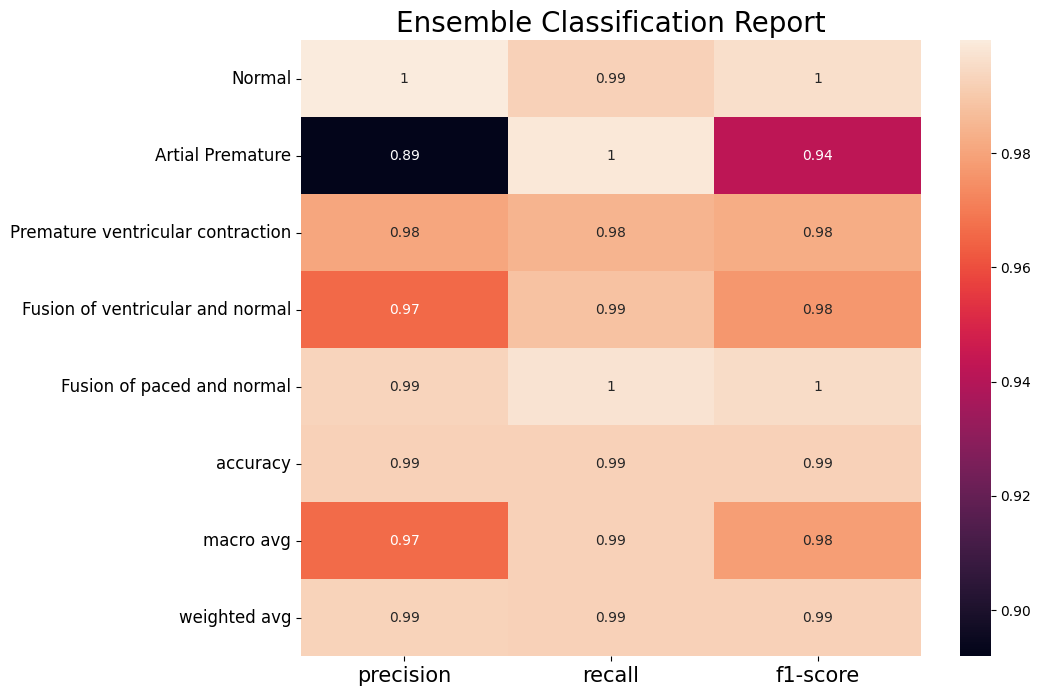

In [ ]:
clf_report = classification_report(y_pred, 
                                   y_true,
                                   labels=[0,1,2,3,4],
                                   target_names=list(id_to_label.values()),#['N', 'S', 'V', 'F', 'Q'],
                                   output_dict=True)


plt.figure(figsize=(10, 8))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12, rotation=0)
plt.title("Ensemble Classification Report", fontsize=20)
plt.savefig(f"ensemble result.svg",format="svg",bbox_inches='tight', pad_inches=0.2)
plt.savefig(f"ensemble result.png", format="png",bbox_inches='tight', pad_inches=0.2)

In [ ]:
clf_report

{'Normal': {'precision': 0.9997792332033262,
  'recall': 0.9924757104244284,
  'f1-score': 0.9961140846103086,
  'support': 13689},
 'Artial Premature': {'precision': 0.8918918918918919,
  'recall': 0.9985590778097982,
  'f1-score': 0.9422161794697484,
  'support': 694},
 'Premature ventricular contraction': {'precision': 0.9806451612903225,
  'recall': 0.9842738205365402,
  'f1-score': 0.9824561403508771,
  'support': 1081},
 'Fusion of ventricular and normal': {'precision': 0.9658119658119658,
  'recall': 0.9883381924198251,
  'f1-score': 0.9769452449567723,
  'support': 343},
 'Fusion of paced and normal': {'precision': 0.9933665008291874,
  'recall': 0.9975020815986678,
  'f1-score': 0.9954299958454508,
  'support': 1201},
 'accuracy': 0.9924741298212606,
 'macro avg': {'precision': 0.9662989506053389,
  'recall': 0.992229776557852,
  'f1-score': 0.9786323290466316,
  'support': 17008},
 'weighted avg': {'precision': 0.9930229884417627,
  'recall': 0.9924741298212606,
  'f1-score':